<a href="https://colab.research.google.com/github/shailshree23/ML_Lab/blob/main/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# -------------------------------
# Generate Exoplanet Dataset
# -------------------------------
def generate_exoplanet_dataset(num_records=5500):
    np.random.seed(43)
    random.seed(43)

    data = {}

    # Feature 1: Exoplanet Name
    exoplanet_names = []
    for i in range(num_records):
        if random.random() < 0.7:
            prefix = random.choice(['WASP-', 'Kepler-', 'HD ', 'HAT-P-'])
            num = random.randint(1, 4000)
            suffix = random.choice(['b', 'c', 'd', 'e'])
            exoplanet_names.append(f'{prefix}{num}{suffix}')
        else:
            name_parts = ['Nova', 'Astro', 'Xylos', 'Zeta', 'Orion',
                          'Eridanus', 'Celestia', 'Starlight', 'Cosmo']
            exoplanet_names.append(
                f'{random.choice(name_parts)}-{random.randint(10,99)}-{random.choice(["Alpha", "Beta", "Gamma"])}'
            )
    data['exoplanet_name'] = exoplanet_names

    # Feature 2: Discovery Year
    data['discovery_year'] = np.random.randint(1995, 2024, size=num_records)

    # Feature 3: Discovery Method
    methods = ['Transit', 'Radial Velocity', 'Direct Imaging',
               'Microlensing', 'Astrometry', 'Timing Variations']
    data['discovery_method'] = np.random.choice(
        methods, size=num_records,
        p=[0.45, 0.30, 0.10, 0.08, 0.05, 0.02]
    )

    # Feature 4: Exoplanet Mass (Jupiter Masses)
    data['exoplanet_mass_mjup'] = np.exp(np.random.normal(0.0, 1.5, num_records))
    data['exoplanet_mass_mjup'] = np.round(data['exoplanet_mass_mjup'], 3)
    data['exoplanet_mass_mjup'][data['exoplanet_mass_mjup'] < 0.001] = 0.001

    # Feature 5: Exoplanet Radius (Jupiter Radii)
    data['exoplanet_radius_rjup'] = np.random.normal(
        loc=np.sqrt(data['exoplanet_mass_mjup']) * 0.8, scale=0.2
    )
    data['exoplanet_radius_rjup'] = np.round(
        np.clip(data['exoplanet_radius_rjup'], 0.1, 2.5), 3
    )

    # Feature 6: Orbital Period (Earth Days)
    data['orbital_period_days'] = np.exp(np.random.normal(4, 2, num_records))
    data['orbital_period_days'] = np.round(data['orbital_period_days'], 2)
    data['orbital_period_days'][data['orbital_period_days'] < 0.5] = 0.5

    # Feature 7: Equilibrium Temperature (Kelvin)
    data['equilibrium_temp_k'] = np.random.normal(300, 200, num_records)
    data['equilibrium_temp_k'] = np.round(
        np.clip(data['equilibrium_temp_k'], 50, 2000), 0
    ).astype(int)

    # Feature 8: Host Star Type
    star_types = ['G', 'K', 'M', 'F', 'A', 'B', 'O']
    data['host_star_type'] = np.random.choice(
        star_types, size=num_records,
        p=[0.25, 0.20, 0.30, 0.15, 0.07, 0.02, 0.01]
    )

    # Feature 9: Host Star Distance (Light Years)
    data['host_star_distance_ly'] = np.exp(np.random.normal(3, 1.5, num_records))
    data['host_star_distance_ly'] = np.round(data['host_star_distance_ly'], 2)
    data['host_star_distance_ly'][data['host_star_distance_ly'] < 5] = 5

    # Feature 10: Habitable Zone Candidate (Boolean target)
    data['habitable_zone_candidate'] = (
        (data['equilibrium_temp_k'] >= 273) &
        (data['equilibrium_temp_k'] <= 373)
    )

    return pd.DataFrame(data)

# Generate dataset
exoplanet_df = generate_exoplanet_dataset()
print("Dataset Shape:", exoplanet_df.shape)
print(exoplanet_df.head())

# -------------------------------
# Prepare Features & Target
# -------------------------------
X = exoplanet_df.drop(columns=['habitable_zone_candidate', 'exoplanet_name'])
y = exoplanet_df['habitable_zone_candidate']

# One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True)

# -------------------------------
# Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# -------------------------------
# K-Fold Cross Validation
# -------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

print("\nCross Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())



# -------------------------------
# 3-Way Split (Train/Validation/Test)
# -------------------------------
# First split: Train + Temp (validation+test)
X_train_3way, X_temp, y_train_3way, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: Validation and Test (50%-50% of temp)
X_val, X_test_3way, y_val, y_test_3way = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("\n3-Way Split Shapes:")
print("Train:", X_train_3way.shape)
print("Validation:", X_val.shape)
print("Test:", X_test_3way.shape)

# Train Logistic Regression on train set
model_3way = LogisticRegression(max_iter=1000, random_state=42)
model_3way.fit(X_train_3way, y_train_3way)

# Evaluate on validation set
y_val_pred = model_3way.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print("\n3-Way Split Validation Accuracy:", val_acc)

# Evaluate on test set
y_test_pred = model_3way.predict(X_test_3way)
test_acc = accuracy_score(y_test_3way, y_test_pred)
print("3-Way Split Test Accuracy:", test_acc)

# 3) k-Fold Cross-Validation (k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = LogisticRegression(max_iter=1000, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

print(f"5-Fold CV Accuracies: {cv_scores}")
print(f"5-Fold CV Mean Accuracy: {np.mean(cv_scores):.4f}")


Dataset Shape: (5500, 10)
  exoplanet_name  discovery_year   discovery_method  exoplanet_mass_mjup  \
0   Kepler-3930e            1999  Timing Variations                0.924   
1     WASP-1857e            1995            Transit                2.263   
2    HAT-P-2362d            2012     Direct Imaging                1.182   
3    HAT-P-1614c            2016       Microlensing                0.285   
4     WASP-3360b            2021    Radial Velocity                0.301   

   exoplanet_radius_rjup  orbital_period_days  equilibrium_temp_k  \
0                  0.669                83.06                 795   
1                  1.196               101.21                 268   
2                  1.393                96.85                 475   
3                  0.330                24.66                 134   
4                  0.734                82.94                 422   

  host_star_type  host_star_distance_ly  habitable_zone_candidate  
0              G                  

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre


Accuracy: 0.8081818181818182

Classification Report:
               precision    recall  f1-score   support

       False       0.81      1.00      0.89       889
        True       0.00      0.00      0.00       211

    accuracy                           0.81      1100
   macro avg       0.40      0.50      0.45      1100
weighted avg       0.65      0.81      0.72      1100



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Cross Validation Scores: [0.80727273 0.81363636 0.80909091 0.79454545 0.81636364]
Mean Accuracy: 0.8081818181818182

3-Way Split Shapes:
Train: (3850, 17)
Validation: (825, 17)
Test: (825, 17)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



3-Way Split Validation Accuracy: 0.8084848484848485
3-Way Split Test Accuracy: 0.8084848484848485


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

5-Fold CV Accuracies: [0.80727273 0.81363636 0.80909091 0.79454545 0.81636364]
5-Fold CV Mean Accuracy: 0.8082


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# -------------------------------
# Imports
# -------------------------------
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# Dataset Generation
# -------------------------------
def generate_exoplanet_dataset(num_records=5500):
    np.random.seed(43)
    random.seed(43)

    data = {}

    # Exoplanet Name
    exoplanet_names = []
    for i in range(num_records):
        if random.random() < 0.7:
            prefix = random.choice(['WASP-', 'Kepler-', 'HD ', 'HAT-P-'])
            num = random.randint(1, 4000)
            suffix = random.choice(['b', 'c', 'd', 'e'])
            exoplanet_names.append(f'{prefix}{num}{suffix}')
        else:
            name_parts = ['Nova', 'Astro', 'Xylos', 'Zeta', 'Orion',
                          'Eridanus', 'Celestia', 'Starlight', 'Cosmo']
            exoplanet_names.append(
                f'{random.choice(name_parts)}-{random.randint(10,99)}-{random.choice(["Alpha", "Beta", "Gamma"])}'
            )
    data['exoplanet_name'] = exoplanet_names

    # Discovery Year
    data['discovery_year'] = np.random.randint(1995, 2024, size=num_records)

    # Discovery Method
    methods = ['Transit', 'Radial Velocity', 'Direct Imaging',
               'Microlensing', 'Astrometry', 'Timing Variations']
    data['discovery_method'] = np.random.choice(
        methods, size=num_records,
        p=[0.45, 0.30, 0.10, 0.08, 0.05, 0.02]
    )

    # Exoplanet Mass
    data['exoplanet_mass_mjup'] = np.exp(np.random.normal(0.0, 1.5, num_records))
    data['exoplanet_mass_mjup'] = np.round(data['exoplanet_mass_mjup'], 3)
    data['exoplanet_mass_mjup'][data['exoplanet_mass_mjup'] < 0.001] = 0.001

    # Exoplanet Radius
    data['exoplanet_radius_rjup'] = np.random.normal(
        loc=np.sqrt(data['exoplanet_mass_mjup']) * 0.8, scale=0.2
    )
    data['exoplanet_radius_rjup'] = np.round(
        np.clip(data['exoplanet_radius_rjup'], 0.1, 2.5), 3
    )

    # Orbital Period
    data['orbital_period_days'] = np.exp(np.random.normal(4, 2, num_records))
    data['orbital_period_days'] = np.round(data['orbital_period_days'], 2)
    data['orbital_period_days'][data['orbital_period_days'] < 0.5] = 0.5

    # Equilibrium Temperature
    data['equilibrium_temp_k'] = np.random.normal(300, 200, num_records)
    data['equilibrium_temp_k'] = np.round(
        np.clip(data['equilibrium_temp_k'], 50, 2000), 0
    ).astype(int)

    # Host Star Type
    star_types = ['G', 'K', 'M', 'F', 'A', 'B', 'O']
    data['host_star_type'] = np.random.choice(
        star_types, size=num_records,
        p=[0.25, 0.20, 0.30, 0.15, 0.07, 0.02, 0.01]
    )

    # Host Star Distance
    data['host_star_distance_ly'] = np.exp(np.random.normal(3, 1.5, num_records))
    data['host_star_distance_ly'] = np.round(data['host_star_distance_ly'], 2)
    data['host_star_distance_ly'][data['host_star_distance_ly'] < 5] = 5

    # Habitable Zone Candidate
    data['habitable_zone_candidate'] = (
        (data['equilibrium_temp_k'] >= 273) &
        (data['equilibrium_temp_k'] <= 373)
    )

    return pd.DataFrame(data)

# Generate dataset
df = generate_exoplanet_dataset()
print("Dataset Shape:", df.shape)

# -------------------------------
# Features & Target
# -------------------------------
X = df.drop(columns=['habitable_zone_candidate', 'exoplanet_name'])
y = df['habitable_zone_candidate']

# One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------------
# 2-Way Split
# -------------------------------
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

model_2 = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
model_2.fit(X_train_2, y_train_2)
y_pred_2 = model_2.predict(X_test_2)

print("\n--- 2-Way Split ---")
print("Accuracy:", accuracy_score(y_test_2, y_pred_2))
print("Confusion Matrix:\n", confusion_matrix(y_test_2, y_pred_2))
print(classification_report(y_test_2, y_pred_2))

# -------------------------------
# 3-Way Split
# -------------------------------
X_train_3, X_temp, y_train_3, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test_3, y_val, y_test_3 = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

model_3 = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
model_3.fit(X_train_3, y_train_3)

y_val_pred = model_3.predict(X_val)
y_test_pred = model_3.predict(X_test_3)

print("\n--- 3-Way Split ---")
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test_3, y_test_pred))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test_3, y_test_pred))
print(classification_report(y_test_3, y_test_pred))

# -------------------------------
# K-Fold Cross-Validation
# -------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_kf = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
cv_scores = cross_val_score(model_kf, X_scaled, y, cv=kf, scoring='accuracy')

print("\n--- 5-Fold Cross Validation ---")
print("CV Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

# Optional: Confusion matrix for K-Fold predictions
# (Average predictions over folds not standard, so usually confusion matrix shown for final split)


Dataset Shape: (5500, 10)

--- 2-Way Split ---
Accuracy: 0.5336363636363637
Confusion Matrix:
 [[489 400]
 [113  98]]
              precision    recall  f1-score   support

       False       0.81      0.55      0.66       889
        True       0.20      0.46      0.28       211

    accuracy                           0.53      1100
   macro avg       0.50      0.51      0.47      1100
weighted avg       0.69      0.53      0.58      1100


--- 3-Way Split ---
Validation Accuracy: 0.5309090909090909
Test Accuracy: 0.5454545454545454
Confusion Matrix (Test):
 [[367 300]
 [ 75  83]]
              precision    recall  f1-score   support

       False       0.83      0.55      0.66       667
        True       0.22      0.53      0.31       158

    accuracy                           0.55       825
   macro avg       0.52      0.54      0.48       825
weighted avg       0.71      0.55      0.59       825


--- 5-Fold Cross Validation ---
CV Scores: [0.54545455 0.56090909 0.53636364 0.5018

Dataset Shape: (5500, 10)

--- 2-Way Split ---
Accuracy: 0.5336363636363637
              precision    recall  f1-score   support

       False       0.81      0.55      0.66       889
        True       0.20      0.46      0.28       211

    accuracy                           0.53      1100
   macro avg       0.50      0.51      0.47      1100
weighted avg       0.69      0.53      0.58      1100



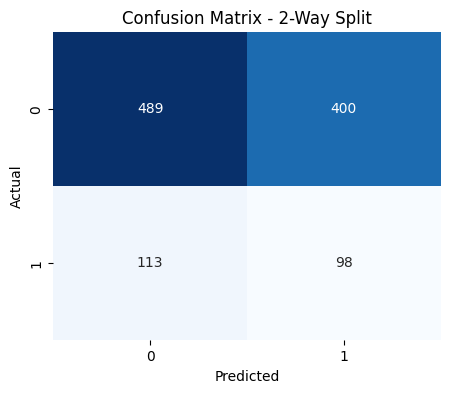


--- 3-Way Split ---
Validation Accuracy: 0.5309090909090909
Test Accuracy: 0.5454545454545454
              precision    recall  f1-score   support

       False       0.83      0.55      0.66       667
        True       0.22      0.53      0.31       158

    accuracy                           0.55       825
   macro avg       0.52      0.54      0.48       825
weighted avg       0.71      0.55      0.59       825



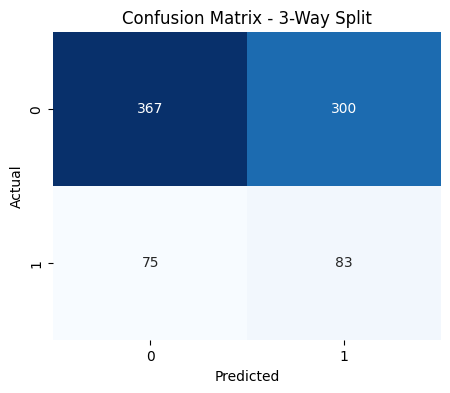


--- 5-Fold Cross Validation ---
CV Scores: [0.54545455 0.56090909 0.53636364 0.50181818 0.55545455]
Mean Accuracy: 0.54


In [ ]:
# -------------------------------
# Imports
# -------------------------------
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# Dataset Generation
# -------------------------------
def generate_exoplanet_dataset(num_records=5500):
    np.random.seed(43)
    random.seed(43)

    data = {}

    # Exoplanet Name
    exoplanet_names = []
    for i in range(num_records):
        if random.random() < 0.7:
            prefix = random.choice(['WASP-', 'Kepler-', 'HD ', 'HAT-P-'])
            num = random.randint(1, 4000)
            suffix = random.choice(['b', 'c', 'd', 'e'])
            exoplanet_names.append(f'{prefix}{num}{suffix}')
        else:
            name_parts = ['Nova', 'Astro', 'Xylos', 'Zeta', 'Orion',
                          'Eridanus', 'Celestia', 'Starlight', 'Cosmo']
            exoplanet_names.append(
                f'{random.choice(name_parts)}-{random.randint(10,99)}-{random.choice(["Alpha", "Beta", "Gamma"])}'
            )
    data['exoplanet_name'] = exoplanet_names

    # Discovery Year
    data['discovery_year'] = np.random.randint(1995, 2024, size=num_records)

    # Discovery Method
    methods = ['Transit', 'Radial Velocity', 'Direct Imaging',
               'Microlensing', 'Astrometry', 'Timing Variations']
    data['discovery_method'] = np.random.choice(
        methods, size=num_records,
        p=[0.45, 0.30, 0.10, 0.08, 0.05, 0.02]
    )

    # Exoplanet Mass
    data['exoplanet_mass_mjup'] = np.exp(np.random.normal(0.0, 1.5, num_records))
    data['exoplanet_mass_mjup'] = np.round(data['exoplanet_mass_mjup'], 3)
    data['exoplanet_mass_mjup'][data['exoplanet_mass_mjup'] < 0.001] = 0.001

    # Exoplanet Radius
    data['exoplanet_radius_rjup'] = np.random.normal(
        loc=np.sqrt(data['exoplanet_mass_mjup']) * 0.8, scale=0.2
    )
    data['exoplanet_radius_rjup'] = np.round(
        np.clip(data['exoplanet_radius_rjup'], 0.1, 2.5), 3
    )

    # Orbital Period
    data['orbital_period_days'] = np.exp(np.random.normal(4, 2, num_records))
    data['orbital_period_days'] = np.round(data['orbital_period_days'], 2)
    data['orbital_period_days'][data['orbital_period_days'] < 0.5] = 0.5

    # Equilibrium Temperature
    data['equilibrium_temp_k'] = np.random.normal(300, 200, num_records)
    data['equilibrium_temp_k'] = np.round(
        np.clip(data['equilibrium_temp_k'], 50, 2000), 0
    ).astype(int)

    # Host Star Type
    star_types = ['G', 'K', 'M', 'F', 'A', 'B', 'O']
    data['host_star_type'] = np.random.choice(
        star_types, size=num_records,
        p=[0.25, 0.20, 0.30, 0.15, 0.07, 0.02, 0.01]
    )

    # Host Star Distance
    data['host_star_distance_ly'] = np.exp(np.random.normal(3, 1.5, num_records))
    data['host_star_distance_ly'] = np.round(data['host_star_distance_ly'], 2)
    data['host_star_distance_ly'][data['host_star_distance_ly'] < 5] = 5

    # Habitable Zone Candidate
    data['habitable_zone_candidate'] = (
        (data['equilibrium_temp_k'] >= 273) &
        (data['equilibrium_temp_k'] <= 373)
    )

    return pd.DataFrame(data)

# Generate dataset
df = generate_exoplanet_dataset()
print("Dataset Shape:", df.shape)

# -------------------------------
# Features & Target
# -------------------------------
X = df.drop(columns=['habitable_zone_candidate', 'exoplanet_name'])
y = df['habitable_zone_candidate']

# One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------------
# Function to plot confusion matrix using seaborn
# -------------------------------
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# -------------------------------
# 2-Way Split
# -------------------------------
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

model_2 = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
model_2.fit(X_train_2, y_train_2)
y_pred_2 = model_2.predict(X_test_2)

print("\n--- 2-Way Split ---")
print("Accuracy:", accuracy_score(y_test_2, y_pred_2))
print(classification_report(y_test_2, y_pred_2))
plot_confusion(y_test_2, y_pred_2, "Confusion Matrix - 2-Way Split")

# -------------------------------
# 3-Way Split
# -------------------------------
X_train_3, X_temp, y_train_3, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test_3, y_val, y_test_3 = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

model_3 = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
model_3.fit(X_train_3, y_train_3)

y_val_pred = model_3.predict(X_val)
y_test_pred = model_3.predict(X_test_3)

print("\n--- 3-Way Split ---")
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test_3, y_test_pred))
print(classification_report(y_test_3, y_test_pred))
plot_confusion(y_test_3, y_test_pred, "Confusion Matrix - 3-Way Split")

# -------------------------------
# K-Fold Cross-Validation
# -------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_kf = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
cv_scores = cross_val_score(model_kf, X_scaled, y, cv=kf, scoring='accuracy')

print("\n--- 5-Fold Cross Validation ---")
print("CV Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
